# testing 'likeness' of tracks for deconv quality

In [96]:
import sys,os,os.path

sys.path.append(os.path.expanduser('~/code/eol_hsrl_python')) # code breaks if you take this line out
os.environ['ICTDIR']='/Users/halmamol/NEXT/IC'

#%load_ext autoreload
#%autoreload 2
#%matplotlib notebook

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['figure.figsize'] = [10, 8]
rcParams['font.size'] = 22

import pandas as pd
import numpy  as np
import tables as tb
import math as m

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as clrs

import IC.invisible_cities.core.core_functions                   as     coref
import IC.invisible_cities.io.dst_io                           as     dstio

from IC.invisible_cities.cities                 import beersheba as beerfun


from IC.invisible_cities.database.load_db       import DataSiPM

from IC.invisible_cities.evm.event_model        import Cluster, Hit
from IC.invisible_cities.types.ic_types         import xy
from IC.invisible_cities.reco.paolina_functions import voxelize_hits

from IC.invisible_cities.evm.event_model        import HitEnergy
from IC.invisible_cities.cities.beersheba          import DeconvolutionMode
from IC.invisible_cities.cities.beersheba          import CutType


from IC.invisible_cities.reco.deconv_functions import deconvolve
from IC.invisible_cities.reco.deconv_functions import deconvolution_input
from IC.invisible_cities.reco.deconv_functions import InterpolationMethod

import IC.invisible_cities.io.mcinfo_io as mcio

## parameter searching
from os import walk
from sklearn.model_selection import ParameterGrid

import matplotlib.cm as cm
from matplotlib.colors import Normalize

In [97]:
# Input file and some event IDs to look at.
dist = 12
typefile = 'esmeralda' #'esmeralda'
#file = f'/Users/halmamol/NEXT/files/NEXT100/separated/esmeralda/esmeralda_10_sep.h5'
file = f'data/data/0nubb/only_separated_tracks/esmeralda/esmeralda_22_sep.h5'
#file = f'/Users/halmamol/NEXT/files/FLEX/ELdistMask/Xe/bb0nu/{typefile}/NextFlex.bb0nu.FLEXELdist{dist}mask.0.detsim.h5'
evts = [90] #15, 30, 90
pitch = 15.55
detector_db     = 'localdb.Flex100DB.sqlite3'
run_number      = -1

datatype = 'MC'


# Parameters involved in beersheba city and the deconvolution.

deconv_params = dict(
  q_cut           = 1, #5 for 6mm  - 5 for 6mm
  drop_dist       = [16, 16],
  #psf_fname       = f'/Users/halmamol/NEXT/PSF_FLEX100_mask{dist}_lowQE.h5',     
  psf_fname       = f'data/data/LightTables/NEXT100_PSF_kr83m.h5',     
  e_cut           = 12e-3, #15 for 6mm  - 15 for 6mm
  n_iterations    = 50, #150 for 6mm  - 150 for 6mm
  iteration_tol   = 1e-10,
  sample_width    = [15.55, 15.55],
  bin_size        = [ 1,  1],
  diffusion       = (1., 0.2),
  n_dim           = 2,
  deconv_mode     = DeconvolutionMode.joint)#,
 # energy_type     = HitEnergy.Ec,
 # cut_type        = CutType.abs,
 # inter_method    = InterpolationMethod.cubic)


#DeconvolutionMode
                
deconv_params_   = {k : v for k, v in deconv_params.items() if k not in ['q_cut', 'drop_dist']}

# Couple of functions used in beersheba.

cut_sensors       = beerfun.cut_over_Q   (deconv_params['q_cut'    ], ['E', 'Ec'])
drop_sensors      = beerfun.drop_isolated(deconv_params['drop_dist'], ['E', 'Ec'])

In [98]:
deconv_params

{'q_cut': 1,
 'drop_dist': [16, 16],
 'psf_fname': 'data/data/LightTables/NEXT100_PSF_kr83m.h5',
 'e_cut': 0.012,
 'n_iterations': 50,
 'iteration_tol': 1e-10,
 'sample_width': [15.55, 15.55],
 'bin_size': [1, 1],
 'diffusion': (1.0, 0.2),
 'n_dim': 2,
 'deconv_mode': <DeconvolutionMode.joint: 'joint'>}

In [99]:
#### INPUTTING SIPM SIGNAL

if(typefile == 'esmeralda'): hdst = dstio.load_dst(file, 'CHITS', 'lowTh')#CHITS/lowTh
elif(typefile == 'penthesilea'): hdst = dstio.load_dst(file, 'RECO', 'Events')#CHITS/lowTh

In [100]:
#### EVENT SELECTION
# selects specific event
n = 0


evt  = hdst.event.unique()[n]
hits = hdst[hdst.event == evt]

In [101]:
hits.head()

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
0,21002,2.100340e+10,0,-124.723137,366.380013,1,-85.525,318.775,0.000000e+00,0.000000e+00,761.481420,5.159420,2310.000000,-1.0,0.006676,-1,-1.0
1,21002,2.100340e+10,0,-124.723137,366.380013,1,-116.625,334.325,0.000000e+00,0.000000e+00,762.322785,7.072464,362.534100,-1.0,0.001074,-1,-1.0
2,21002,2.100340e+10,0,-124.723137,366.380013,1,-85.525,334.325,1.421085e-14,0.000000e+00,762.322785,7.072464,362.534100,-1.0,0.001057,-1,-1.0
3,21002,2.100340e+10,0,-124.723137,366.380013,1,-101.075,334.325,1.421085e-14,5.684342e-14,762.322785,6.376812,326.874993,-1.0,0.000960,-1,-1.0
4,21002,2.100340e+10,0,-124.723137,366.380013,1,-101.075,318.775,0.000000e+00,0.000000e+00,762.322785,5.043478,258.528419,-1.0,0.000752,-1,-1.0


In [102]:
# number of unique events
print(evt)

21002


In [103]:
#### BINNING WRT RANGE AND MIDPOINTS OF X,Y,Z POSITIONS

x_range = (hits.X.max()-hits.X.min())/2.
y_range = (hits.Y.max()-hits.Y.min())/2.
z_range = (hits.Z.max()-hits.Z.min())/2.
mid_x   = (hits.X.max()+hits.X.min())/2.
mid_y   = (hits.Y.max()+hits.Y.min())/2.
mid_z   = (hits.Z.max()+hits.Z.min())/2.

xbins = int(hits.X.max()-hits.X.min())
ybins = int(hits.Y.max()-hits.Y.min())
zbins = int((hits.Z.max()-hits.Z.min())/2.)

In [104]:
#### COLLECTING TRUE INFORMATION FROM SAME FILE

if (datatype == 'MC'):
    evtmap = mcio.load_eventnumbermap(file).set_index('nexus_evt')
    true_info = mcio.load_mchits_df(file).reset_index()
    true_info.event_id = true_info.event_id.map(evtmap.evt_number)
    
    
    this_evt_true_info = true_info[true_info.event_id == evt]

    xt = this_evt_true_info.x
    yt = this_evt_true_info.y
    zt = this_evt_true_info.z
    et = this_evt_true_info.energy*1000

In [105]:
# THIS EVENTS TRUE INFO
this_evt_true_info.head()

,event_id,particle_id,hit_id,x,y,z,time,energy,label
0,21002,2,0,-95.513939,345.303253,784.437683,0.003413,0.029655,ACTIVE
1,21002,2,1,-95.821793,346.205078,784.136658,0.006826,0.011418,ACTIVE
2,21002,2,2,-96.160179,347.101959,783.855469,0.010239,0.004941,ACTIVE
3,21002,2,3,-96.549751,348.003204,783.673523,0.013651,0.008632,ACTIVE
4,21002,2,4,-97.032021,348.869568,783.566345,0.017059,0.005226,ACTIVE


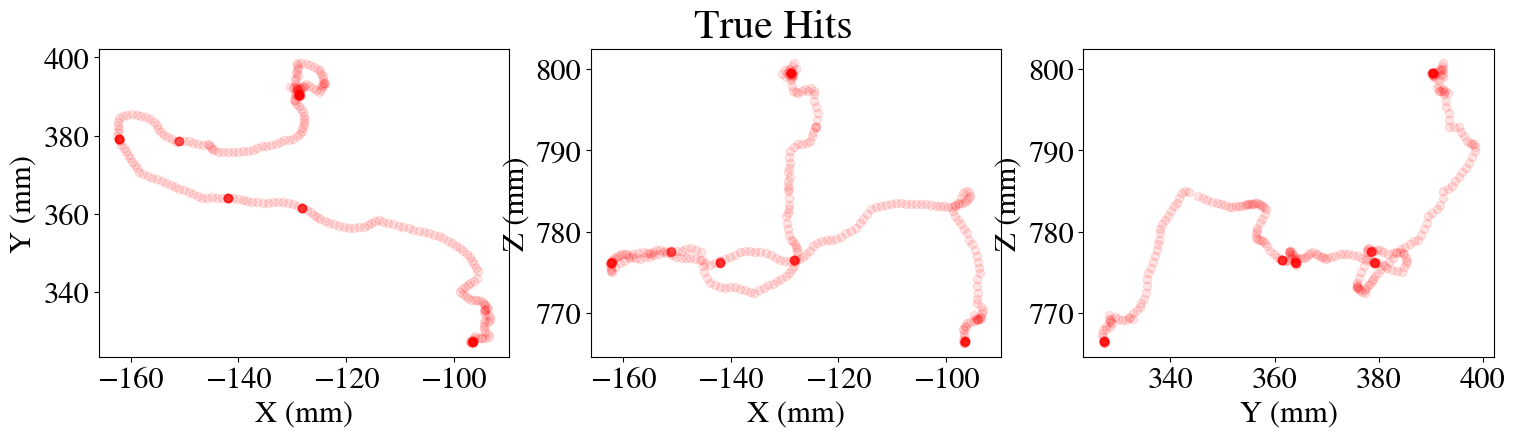

In [106]:
# true data type plots
if (datatype == 'MC'):
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    axes[0].scatter(xt, yt,  alpha=0.1, color='red')
    axes[0].set_xlabel('X (mm)');
    axes[0].set_ylabel('Y (mm)');

    axes[1].scatter(xt, zt,  alpha=0.1, color='red')
    axes[1].set_xlabel('X (mm)');
    axes[1].set_ylabel('Z (mm)');

    axes[2].scatter(yt, zt,  alpha=0.1, color='red')
    axes[2].set_xlabel('Y (mm)');
    axes[2].set_ylabel('Z (mm)');
    
    fig.suptitle('True Hits', fontsize=30)

From this point, the signals are then transformed into 'sipm sensor signals' and cut etc etc.

Text(0.5, 0.98, 'Sensors Signal')

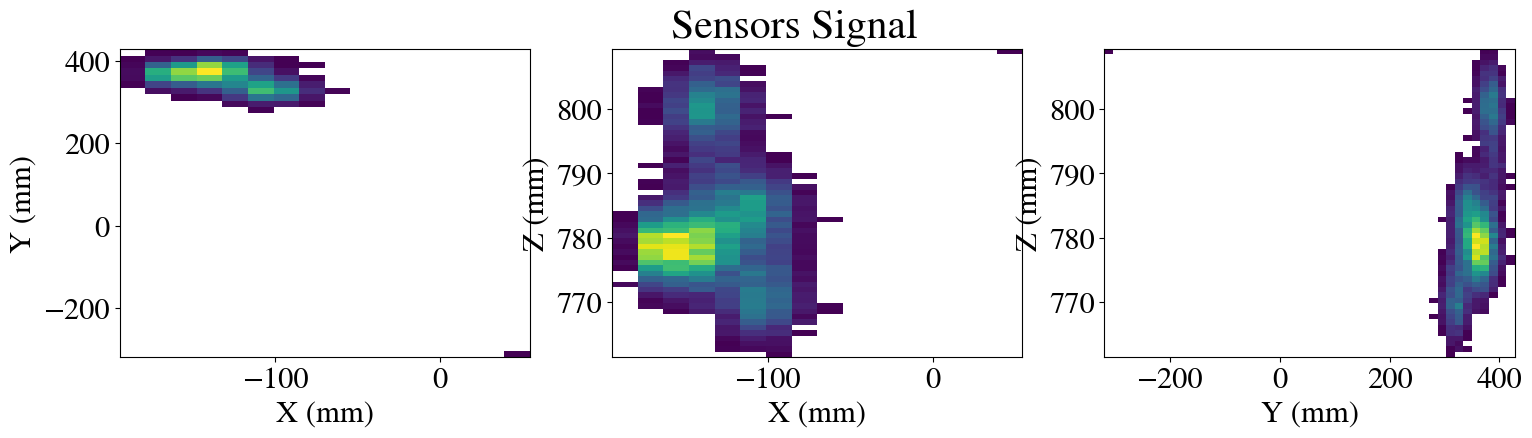

In [107]:
# then applying transformations to convert to 'SiPM outputs'
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

xx = np.arange(hits.X.min(), hits.X.max() + pitch, pitch)
yy = np.arange(hits.Y.min(), hits.Y.max() + pitch, pitch)
zz = hits.Z.unique()

axes[0].hist2d(hits.X, hits.Y, bins=[xx, yy], weights=hits.Q, cmin=0.0001);
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(hits.X, hits.Z, bins=[xx, zz], weights=hits.Q, cmin=0.0001);
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');


axes[2].hist2d(hits.Y, hits.Z, bins=[yy, zz], weights=hits.Q, cmin=0.0001);
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');

fig.suptitle('Sensors Signal', fontsize=30)

Trying to convolve it without cutting first

In [108]:
deconvolver = beerfun.deconvolve_signal(DataSiPM(detector_db, run_number), **deconv_params_)
hits_deco = coref.timefunc(deconvolver)(hits.copy())

Time spent in apply_deconvolution: 7.470517873764038 s


In [109]:
for iterN in np.arange(15, deconv_params_['n_iterations'], 15):
    deconv_params_['n_iterations'] = iterN
    deconvolver = beerfun.deconvolve_signal(DataSiPM(detector_db, run_number), **deconv_params_)
    print(f'{iterN} iterations')
    hits_deco = coref.timefunc(deconvolver)(hits.copy())

15 iterations
Time spent in apply_deconvolution: 2.598292350769043 s
30 iterations
Time spent in apply_deconvolution: 4.758041143417358 s
45 iterations
Time spent in apply_deconvolution: 6.3201844692230225 s


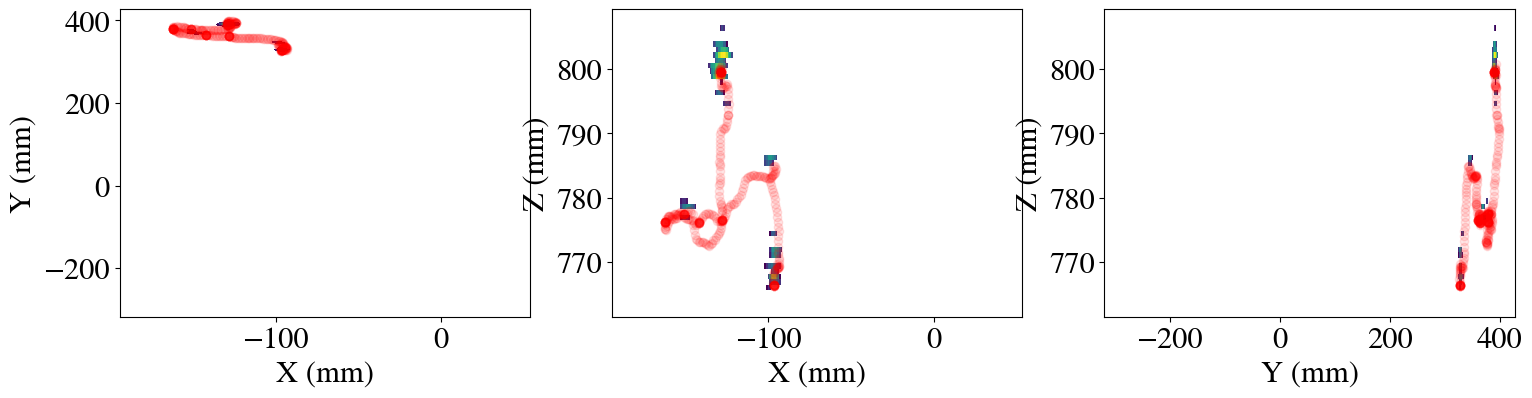

In [110]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

xx = np.arange(hits.X.min(), hits.X.max())
yy = np.arange(hits.Y.min(), hits.Y.max())
zz = hits.Z.unique()

axes[0].hist2d(hits_deco.X, hits_deco.Y, bins=[xx, yy], weights=hits_deco.E, cmin=0.0001);
if (datatype == 'MC'):
    axes[0].scatter(xt, yt,  alpha=0.1, color='red')
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(hits_deco.X, hits_deco.Z, bins=[xx, zz], weights=hits_deco.E, cmin=0.0001);
if (datatype == 'MC'):
    axes[1].scatter(xt, zt,  alpha=0.1, color='red')
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');

axes[2].hist2d(hits_deco.Y, hits_deco.Z, bins=[yy, zz], weights=hits_deco.E, cmin=0.0001);
if (datatype == 'MC'):
    axes[2].scatter(yt, zt,  alpha=0.1, color='red')
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');

Collect the values from the true data and the convoluted hits as arrays. Start with 2D

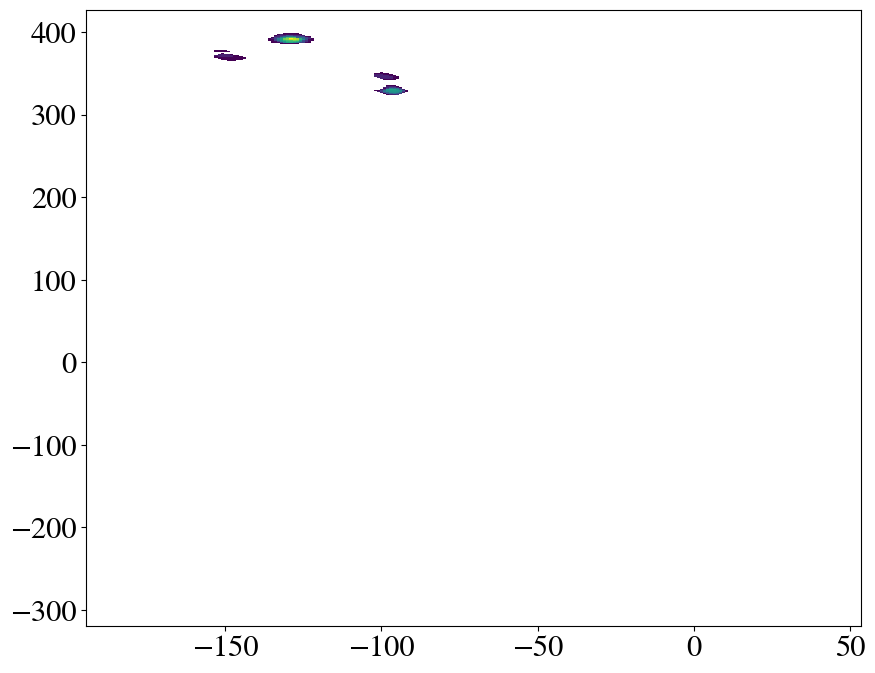

In [111]:
plt.hist2d(hits_deco.X, hits_deco.Y, bins = [xx, yy], cmin=0.0001, weights = hits_deco.E)
plt.show()
# so hits_deco.X and hits_deco.Y show this

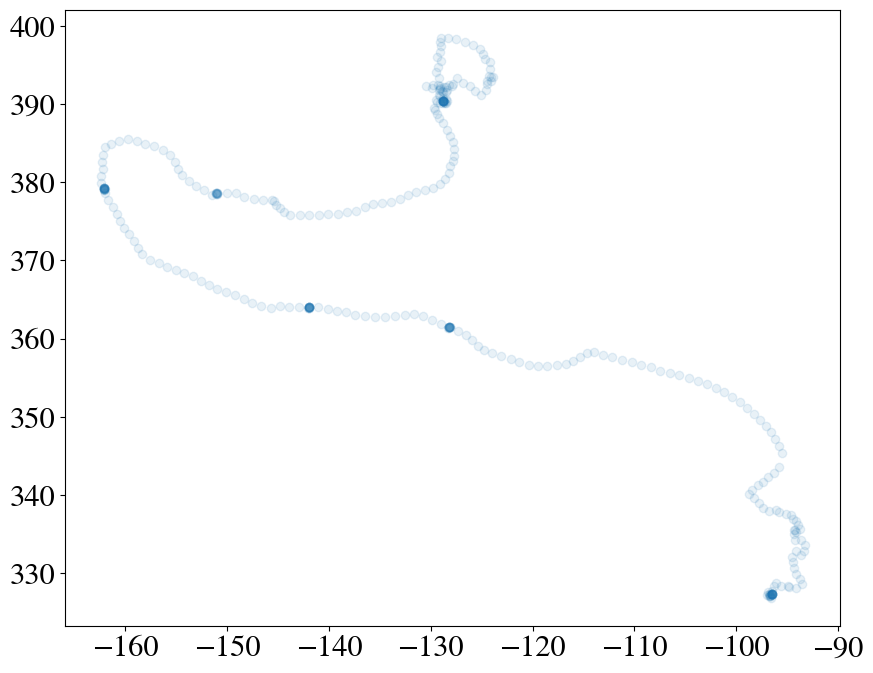

In [112]:
plt.scatter(xt, yt, alpha = 0.1)
plt.show()

In [113]:
def pandas_to_numpy_round(a):
    return np.around(a.to_numpy(), decimals = 2)


print(len(xt), len(hits_deco.X))
# convert xt into array
xta = pandas_to_numpy_round(xt)
hits_deco_a = pandas_to_numpy_round(hits_deco.X)

print(hits_deco_a)
print("===")
print(xta)
# so the lengths vary depending on the input

339 1010
[-100.55  -99.55  -99.55 ... -126.55 -126.55 -126.55]
===
[ -95.51  -95.82  -96.16  -96.55  -97.03  -97.64  -98.28  -98.92  -99.63
 -100.38 -101.16 -101.97 -102.81 -103.71 -104.64 -105.58 -106.53 -107.48
 -108.38 -109.34 -110.26 -111.19 -112.14 -113.06 -113.95 -114.67 -115.35
 -116.   -116.67 -117.6  -118.54 -119.43 -120.36 -121.28 -122.16 -123.09
 -123.98 -124.78 -125.34 -125.92 -126.57 -127.33 -128.12 -129.   -129.85
 -130.75 -131.64 -132.58 -133.53 -134.5  -135.48 -136.45 -137.43 -138.33
 -139.2  -140.1  -141.03 -141.98 -142.   -142.95 -143.9  -144.85 -145.72
 -146.68 -147.56 -148.38 -149.2  -150.1  -150.97 -151.76 -152.58 -153.33
 -154.2  -155.04 -155.93 -156.74 -157.63 -158.34 -158.78 -159.19 -159.66
 -160.19 -160.54 -160.82 -161.27 -161.69 -162.   -162.12 -162.43 -162.41
 -162.17 -162.28 -162.23 -162.05 -161.42 -160.63 -159.73 -158.87 -158.06
 -157.16 -156.33 -155.6  -155.15 -154.87 -154.41 -153.76 -153.04 -152.24
 -151.53 -151.   -150.05 -149.09 -148.33 -147.4  -146.51 

In [ ]:
# functions that

# creates x,y,z coordinate positions for true and deconvoluted data
deconv_array = np.dstack([hits_deco.X, hits_deco.Y, hits_deco.Z])[0]
true_array = np.dstack([xt, yt, zt])[0]

print(deconv_array[0])
print('=====')
print(true_array[1])
print('=====')
print(np.abs(true_array - deconv_array[0])[0])
print('=====')
full = np.abs(true_array - deconv_array[0])
#print(full.shape)
mag = np.sqrt(full[0][0]**2 + full[0][1]**2 + full[0][2]**2)
#print(mag)

#print(np.min(np.linalg.norm(full, axis = 1, keepdims = True) ))

# scan over deconvolution array, applying to true array and taking the absolute minimum
mag_array = []

for i in range(len(deconv_array)):
    subtract_array = (np.abs(deconv_array[i] - true_array))
    # take minimum magnitude from the subtracted array
    mag_array.append(np.min(np.linalg.norm(subtract_array, axis = 1, keepdims = True)))
    
likeness = np.sum(mag_array) / len(mag_array)
    
print(likeness)
    # take the absolute magnitudes of all the differences

# takes away and find minimum value from (x, y) of true data wrt input
#for i in range(len(deconv_array)):

# takes this value and creates quantitive value for this

In [121]:
def likeliness_calc(deconv_ar, true_ar):
    '''
    produces a 'likeliness value' for the deconvolution output wrt a specific event
    
    input -> x,y,z arrays for deconvoluted data via np.dstack and true data
    '''
    mag_array = []
    likelihood_ar = []
    
    for i in range(len(deconv_ar)):
        # take one deconvoluted value away from the true array
        subtract_array = (np.abs(true_ar - deconv_ar[i]))
        # take minimum magnitude from the subtracted array
        mag_array.append(np.min(np.linalg.norm(subtract_array, axis = 1, keepdims = True)))
        
    # average likeness, giving the sum of all the minimum values normalised by the number of values
    likeness = np.sum(mag_array) / len(mag_array)
    
    # higher values will imply worse reconstructions
    if (m.isnan(likeness) == True):
        print("Likeness NaN, you've not done enough deconvolutions!")
    else:
        print(likeness)
        
    return likeness

In [122]:
# apply likeliness to all events with the same cut, take average

    

# first, need to produce true data and SiPM simulated data in a function
def output_frames(file_name, n, deconv_params):
    '''
    :params: file_name                       name of the file
    :params: n                               event number
    :params: params                          pass in cut parameters
    
    :returns: (truth_arrays, SiPM_arrays)    arrays of truth and SiPM values
    '''
    pitch = 15.55
    # for deconvolution
    deconv_params_   = {k : v for k, v in deconv_params.items() if k not in ['q_cut', 'drop_dist']}
    detector_db     = 'localdb.Flex100DB.sqlite3'
    run_number      = -1

    
    
    #### Collecting file data
    if(typefile == 'esmeralda'): hdst = dstio.load_dst(file_name, 'CHITS', 'lowTh')#CHITS/lowTh
    elif(typefile == 'penthesilea'): hdst = dstio.load_dst(file_name, 'RECO', 'Events')#CHITS/lowTh
    
    # take 1 event
    evt  = hdst.event.unique()[n]
    hits = hdst[hdst.event == evt]
    
    # find x,y,z range; midpoints and bins
    x_range = (hits.X.max()-hits.X.min())/2.
    y_range = (hits.Y.max()-hits.Y.min())/2.
    z_range = (hits.Z.max()-hits.Z.min())/2.
    mid_x   = (hits.X.max()+hits.X.min())/2.
    mid_y   = (hits.Y.max()+hits.Y.min())/2.
    mid_z   = (hits.Z.max()+hits.Z.min())/2.

    xbins = int(hits.X.max()-hits.X.min())
    ybins = int(hits.Y.max()-hits.Y.min())
    zbins = int((hits.Z.max()-hits.Z.min())/2.)
    
 
    # take truth data
    if (datatype == 'MC'):
        evtmap = mcio.load_eventnumbermap(file_name).set_index('nexus_evt')
        true_info = mcio.load_mchits_df(file_name).reset_index()
        true_info.event_id = true_info.event_id.map(evtmap.evt_number)


        this_evt_true_info = true_info[true_info.event_id == evt]

        xt = this_evt_true_info.x
        yt = this_evt_true_info.y
        zt = this_evt_true_info.z
        et = this_evt_true_info.energy*1000
        
    
    # apply SiPM output production
    xx = np.arange(hits.X.min(), hits.X.max() + pitch, pitch)
    yy = np.arange(hits.Y.min(), hits.Y.max() + pitch, pitch)
    zz = hits.Z.unique()
    
    
    ### APPLY ENERGY CUTS
    cut_func = beerfun.cut_over_Q(deconv_params['q_cut'], ['E', 'Ec'])
    h_cut = coref.timefunc(cut_func)(hits.copy())     
                                     
    ### DROP SENSORS
    drop_func = beerfun.drop_isolated(deconv_params['drop_dist'], ['E', 'Ec'])
    h_drop = coref.timefunc(drop_func)(h_cut.copy())
                                     
                                     
    # energy check
    if (np.round(h_drop.E.sum(), 4) != np.round(h_cut.E.sum(), 4)):
        print("Warning: Energy check failed!")
    
    ### DECONVOLVE
    for iterN in np.arange(15, deconv_params_['n_iterations'], 15):
        deconv_params_['n_iterations'] = iterN
        deconvolver = beerfun.deconvolve_signal(DataSiPM(detector_db, run_number), **deconv_params_)
        #print(f'{iterN} iterations')
        h_deco = coref.timefunc(deconvolver)(h_drop.copy())   
                                  
    # creates x,y,z coordinate positions for true and deconvoluted data
    deconv_array = np.dstack([h_deco.X, h_deco.Y, h_deco.Z])[0]
    true_array = np.dstack([xt, yt, zt])[0]
    
    
    # determine likeness
    lkness = likeliness_calc(deconv_array, true_array)
        
    return lkness

In [123]:
deconv_params

{'q_cut': 1,
 'drop_dist': [16, 16],
 'psf_fname': 'data/data/LightTables/NEXT100_PSF_kr83m.h5',
 'e_cut': 0.012,
 'n_iterations': 50,
 'iteration_tol': 1e-10,
 'sample_width': [15.55, 15.55],
 'bin_size': [1, 1],
 'diffusion': (1.0, 0.2),
 'n_dim': 2,
 'deconv_mode': <DeconvolutionMode.joint: 'joint'>}

In [ ]:
output_frames(f'data/data/0nubb/only_separated_tracks/esmeralda/esmeralda_9_sep.h5', 20, deconv_params)

In [124]:
# Collecting files
path_dir = f'data/data/0nubb/only_separated_tracks/esmeralda/'
files = next(walk(path_dir), (None, None, []))[2]
print(files)
print("===")
print(path_dir + files[0])

['esmeralda_9_sep.h5', 'esmeralda_22_sep.h5', 'esmeralda_7_sep.h5', 'esmeralda_6_sep.h5', 'esmeralda_5_sep.h5', 'esmeralda_11_sep.h5', 'esmeralda_27_sep.h5', 'esmeralda_4_sep.h5', 'esmeralda_28_sep.h5', 'esmeralda_2_sep.h5', 'esmeralda_24_sep.h5', 'esmeralda_8_sep.h5', 'esmeralda_14_sep.h5', 'esmeralda_17_sep.h5', 'esmeralda_25_sep.h5', 'esmeralda_18_sep.h5', 'esmeralda_12_sep.h5', 'esmeralda_16_sep.h5', 'esmeralda_29_sep.h5', 'esmeralda_13_sep.h5', 'esmeralda_30_sep.h5', 'esmeralda_26_sep.h5', 'esmeralda_21_sep.h5', 'esmeralda_20_sep.h5', 'esmeralda_19_sep.h5', 'esmeralda_23_sep.h5', 'esmeralda_10_sep.h5', 'esmeralda_1_sep.h5', 'esmeralda_15_sep.h5', 'esmeralda_3_sep.h5']
===
data/data/0nubb/only_separated_tracks/esmeralda/esmeralda_9_sep.h5


### This section scans over all files, with all events within it. This is too much! Just do one file, all events within it and that would take possibly an hour. With one set of deconv_params!

In [125]:
# loop over all files to get likeness values
likeness_vals = []
for i in range(len(files)):
    
    #### Collecting file data
    if(typefile == 'esmeralda'): hdst = dstio.load_dst(path_dir + files[i], 'CHITS', 'lowTh')#CHITS/lowTh
    elif(typefile == 'penthesilea'): hdst = dstio.load_dst(path_dir + files[i], 'RECO', 'Events')#CHITS/lowTh
    
    # take list of events
    evt  = hdst.event.unique()
    
    for j in range(len(evt)):
        likeness_vals.append(output_frames(path_dir + files[i], j, deconv_params))
    

Time spent in cut_over_Q: 0.008081912994384766 s
Time spent in drop_isolated: 0.021753311157226562 s
Time spent in apply_deconvolution: 2.634438991546631 s
Time spent in apply_deconvolution: 4.447521686553955 s


KeyboardInterrupt: 

### So instead lets do one file, n varies, and deconv parameters vary.

In [126]:
#param_grid = {'q_cut': [1, 5, 10, 20, 30, 40, 50], 'drop_dist': [[8,8], [16,16], [32, 32]], 'n_iterations': [100, 200]}
param_grid = {'e_cut': [12e-3, 6e-3, 15e-3]}

In [127]:
p_grid = list(ParameterGrid(param_grid))

In [128]:
print(p_grid[2])
print(p_grid[2]['n_iterations'])
print(len(p_grid))

{'e_cut': 0.015}


KeyError: 'n_iterations'

In [131]:
def alter_deconv_params(grid):
    # create new dictionary
    d_pms = dict(
        q_cut         = 5,#grid['q_cut'],
        drop_dist     = [16, 16],#grid['drop_dist'],
        psf_fname     = f'data/data/LightTables/NEXT100_PSF_kr83m.h5',
        e_cut           = grid['e_cut'], #15 for 6mm  - 15 for 6mm
        n_iterations    = 100, #150 for 6mm  - 150 for 6mm
        iteration_tol   = 1e-10,
        sample_width    = [15.55, 15.55],
        bin_size        = [ 1,  1],
        diffusion       = (1., 0.2),
        n_dim           = 2,
        deconv_mode     = DeconvolutionMode.joint)
    
    return d_pms

In [132]:
file = f'data/data/0nubb/only_separated_tracks/esmeralda/esmeralda_22_sep.h5'

#### Collecting file data
if(typefile == 'esmeralda'): hdst = dstio.load_dst(file, 'CHITS', 'lowTh')#CHITS/lowTh
elif(typefile == 'penthesilea'): hdst = dstio.load_dst(file, 'RECO', 'Events')#CHITS/lowTh

# take N events event
evt  = hdst.event.unique()
# Way too many! so lets just sample over the first 5 events
scan_vals = 5
#hits = hdst[hdst.event == evt]

avg_likeness_list = []
std_likeness_list = []

# scanning over parameter grid for one file, N events in said file
for i in range(len(p_grid)):
    
    # reset array
    likeness_param_srch = []
    
    # create new testing parameters
    n_deconv_params = alter_deconv_params(p_grid[i])
    
    # scan over values
    for j in range(scan_vals):
        likeness_param_srch.append(output_frames(file, j, n_deconv_params))
    print('Likeness for deconv-params\n {}'.format(p_grid[i]))
    print("{}/{}".format(i, len(p_grid)))
    # take average and std of likeness for this set of deconv parameters
    avg_likeness_list.append(np.mean(likeness_param_srch))
    std_likeness_list.append(np.std(likeness_param_srch))
    print("===============")
    


Time spent in cut_over_Q: 0.008006572723388672 s
Time spent in drop_isolated: 0.02168869972229004 s
Time spent in apply_deconvolution: 2.444946527481079 s
Time spent in apply_deconvolution: 4.144853591918945 s
Time spent in apply_deconvolution: 6.2737648487091064 s
Time spent in apply_deconvolution: 7.643417596817017 s
Time spent in apply_deconvolution: 8.980471849441528 s
Time spent in apply_deconvolution: 9.893903970718384 s
3.245243077991879
Time spent in cut_over_Q: 0.00811147689819336 s
Time spent in drop_isolated: 0.0399625301361084 s
Time spent in apply_deconvolution: 4.115069150924683 s
Time spent in apply_deconvolution: 6.79856014251709 s
Time spent in apply_deconvolution: 9.279331922531128 s
Time spent in apply_deconvolution: 13.500610113143921 s
Time spent in apply_deconvolution: 16.613698959350586 s
Time spent in apply_deconvolution: 19.94622254371643 s
3.2423878787830342
Time spent in cut_over_Q: 0.006929159164428711 s
Time spent in drop_isolated: 0.023839473724365234 s
Ti

In [133]:
np.save('likeness_avg_ecut_scan', avg_likeness_list)
np.save('likeness_std_ecut_scan', std_likeness_list)
np.save('likeness_grid_ecut_scan', p_grid)

In [134]:
print(avg_likeness_list)

[3.320793766532386, 4.375692443288271, 2.9233412093507685]


In [135]:

min_index = np.argmin(avg_likeness_list)
print(str(avg_likeness_list[min_index]) + " +/- " + str(std_likeness_list[min_index]))

2.9233412093507685 +/- 0.2062719157981607


In [136]:
print("{}".format(p_grid[min_index]))

{'e_cut': 0.015}


In [137]:
print(p_grid)

[{'e_cut': 0.012}, {'e_cut': 0.006}, {'e_cut': 0.015}]


In [138]:
index_list = np.array(avg_likeness_list).argsort().tolist()[::-1]
print(index_list)

[1, 0, 2]


In [139]:
for i in range(len(index_list)):
    print(p_grid[index_list[i]])

{'e_cut': 0.006}
{'e_cut': 0.012}
{'e_cut': 0.015}


In [140]:
print(avg_likeness_list[15])
print(avg_likeness_list[9])

IndexError: list index out of range